## First step: Upload a file
Upload the data to database, and read cvs to data.

In [1]:
import pandas as pd
import spacy

In [4]:
from google.colab import files
database = files.upload()

Saving MoodyLyrics_anqi_clean (3).csv to MoodyLyrics_anqi_clean (3).csv


In [5]:
import io
data = pd.read_csv(io.BytesIO(database['MoodyLyrics_anqi_clean (3).csv']))

In [2]:
# 这一步可以代替上面两步
from google.colab import drive
drive.mount('/content/drive')
data=pd.read_csv('/content/drive/MyDrive/Sharing/DSW Final Project/dataset/MoodyLyrics_final.csv')

Mounted at /content/drive


FileNotFoundError: ignored

### You can skip this

In [6]:
print(data.head())

            Artist               Title     Mood  \
0            Usher  There Goes My Baby  relaxed   
1         Da'Ville          On My Mind  relaxed   
2          Rihanna       Rockstar 101   relaxed   
3       J. Holiday                 Bed  relaxed   
4  Morgan Heritage   Don't Haffi Dread    angry   

                              Lyrics_after_stopwords  
0  yeah right usher baby okay yeah man right turn...  
1  ahhhhhhhh youre om mind yea verse im thinkin g...  
2  told ya told ya told ya baby baby uh uh told y...  
3  j holiday oooh oooh ayayay ay ayayay ay ayayay...  
4  yeah yeah yeah ragga ragga dont ha fi dread ra...  


In [7]:
first_lyrics = data.loc[0, 'Lyrics_after_stopwords']
print(first_lyrics)

yeah right usher baby okay yeah man right turn lights goes baby oooh girl look dont know good feels girl goes baby loving oooh girl look bet aint know checking putting heels swear bodys perfect baby work baby yeah wooo love way poking girl feel believe gone twerking end night baby ive waiting day wrap hands waist kiss face wouldnt trade feeling minute ill sit long takes soon come walking way gon hear goes baby oooh girl look dont know good feels girl goes baby loving oooh girl look chills face place girl feel like im movie baby im like oowee baby like waterfalls hair falls waist taste girl need creep cause baby aint ashamed calling girl ive waiting day wrap hands waist kiss face wouldnt trade feeling minute ill sit long takes soon come walking way gon hear goes baby oooh girl look dont know good feels girl goes baby loving oooh girl look girl feel like time time baby loving feels better heart dont need ring promise time away wont change love goes baby oooh girl look dont know good feel

## Second Step: Get Pretrain nlp.

In [8]:
!python -m spacy download en_core_web_lg

2023-05-12 22:34:21.116209: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [9]:
spacy_lang = 'en_core_web_lg'
nlp = spacy.load(spacy_lang)

## Third Step: Preprare the Data and Other preparatory work

In [10]:
dataset = data
emotion_labels = ['happy', 'sad', 'relaxed', 'angry']
mapping = dict(zip(emotion_labels, range(len(emotion_labels)))) # { 'happy' : 0, 'sad': 1, 'relaxed': 2, 'angry': 3 }
dataset['Mood'] = dataset['Mood'].map(mapping)

In [11]:
def remove_stopwords(doc):
    tks = list(filter(lambda tk: not tk.is_stop, doc))
    return spacy.tokens.Doc(nlp.vocab, words=[tk.text for tk in tks])

def doc_preprocess(doc):
    d = remove_stopwords(doc)
    return d

In [12]:
import numpy as np
rows = list()
dataset['Vector'] = np.nan
dataset['Vector_Norm'] = np.nan
for index, row in dataset.iterrows():
    if index < 1000:
        name = row['Title']
        emotion = row['Mood']
        lyric = row['Lyrics_after_stopwords']
        if not pd.isna(lyric):
            doc = nlp(lyric)
            doc = doc_preprocess(doc)
            if len(doc.vector) == 300:
                rows.append((
                    name,
                    lyric,
                    emotion, doc.vector,
                    doc.vector_norm
                ))

In [13]:
# Let us see the data!
dd = pd.DataFrame(rows, columns=['Title','Lyrics_after_stopwords', 'Mood', 'Vector', 'Vector_Norm'])
print(dd)

                         Title  \
0           There Goes My Baby   
1                   On My Mind   
2                Rockstar 101    
3                          Bed   
4            Don't Haffi Dread   
..                         ...   
995             Big Difference   
996  Make Out Fall Out Make Up   
997             Because Of You   
998                 Summertime   
999      Blood Sugar Sex Magik   

                                Lyrics_after_stopwords  Mood  \
0    yeah right usher baby okay yeah man right turn...     2   
1    ahhhhhhhh youre om mind yea verse im thinkin g...     2   
2    told ya told ya told ya baby baby uh uh told y...     2   
3    j holiday oooh oooh ayayay ay ayayay ay ayayay...     2   
4    yeah yeah yeah ragga ragga dont ha fi dread ra...     3   
..                                                 ...   ...   
995  quiet kid coming stay says im lonely says im l...     1   
996  records clothes floor remind night pounding pa...     1   
997  theres son

In [14]:
print(dd.loc[0, 'Lyrics_after_stopwords'])

yeah right usher baby okay yeah man right turn lights goes baby oooh girl look dont know good feels girl goes baby loving oooh girl look bet aint know checking putting heels swear bodys perfect baby work baby yeah wooo love way poking girl feel believe gone twerking end night baby ive waiting day wrap hands waist kiss face wouldnt trade feeling minute ill sit long takes soon come walking way gon hear goes baby oooh girl look dont know good feels girl goes baby loving oooh girl look chills face place girl feel like im movie baby im like oowee baby like waterfalls hair falls waist taste girl need creep cause baby aint ashamed calling girl ive waiting day wrap hands waist kiss face wouldnt trade feeling minute ill sit long takes soon come walking way gon hear goes baby oooh girl look dont know good feels girl goes baby loving oooh girl look girl feel like time time baby loving feels better heart dont need ring promise time away wont change love goes baby oooh girl look dont know good feel

In [16]:
#split the dataset
from sklearn.model_selection import train_test_split
X_vect = dd['Vector'].values.T
X_vect = np.array([np.array(x) for x in X_vect])
X_norm = dd['Vector_Norm'].values
y = dd['Mood'].values

# Assuming you have your feature matrix X and target variable y
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42)

## Fourth Step: Train Model

### KNN-success

In [17]:
#parameter tuning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

ks = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

for k in ks:
    # Build model
    clf = KNeighborsClassifier(n_neighbors=k, algorithm='auto', 
                           metric='euclidean', n_jobs=-1)
    # Evaluate accuracy
    scores = cross_val_score(clf, X_train, y_train, cv=10)
    print('Accuracy for k=%d: %0.2f (+/- %0.2f)' % (k, scores.mean(), scores.std() * 1.96))

Accuracy for k=1: 0.69 (+/- 0.09)
Accuracy for k=3: 0.68 (+/- 0.13)
Accuracy for k=5: 0.70 (+/- 0.13)
Accuracy for k=7: 0.72 (+/- 0.12)
Accuracy for k=9: 0.70 (+/- 0.10)
Accuracy for k=11: 0.71 (+/- 0.11)
Accuracy for k=13: 0.71 (+/- 0.12)
Accuracy for k=15: 0.70 (+/- 0.13)
Accuracy for k=17: 0.69 (+/- 0.12)
Accuracy for k=19: 0.70 (+/- 0.10)
Accuracy for k=21: 0.71 (+/- 0.08)


In [19]:
#parameter tuning using grid search
from sklearn.model_selection import GridSearchCV

clf=KNeighborsClassifier()
param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21], 'metric': ['euclidean', 'manhattan']}
grid_search = GridSearchCV(clf, param_grid, cv=10)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 7}
Best Score: 0.72375


In [20]:
#the best model 
clf = KNeighborsClassifier(n_neighbors=7, algorithm='auto', 
                           metric='euclidean', n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [26]:
#classification report
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.92      0.84        66
           1       0.70      0.76      0.73        49
           2       0.89      0.52      0.66        48
           3       0.72      0.76      0.74        37

    accuracy                           0.76       200
   macro avg       0.77      0.74      0.74       200
weighted avg       0.77      0.76      0.75       200



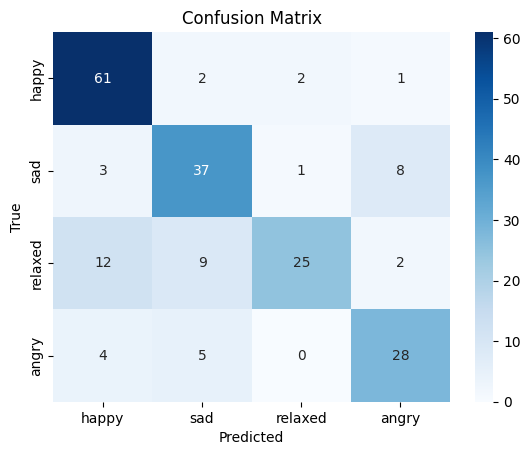

In [27]:
#confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
class_labels = ['happy', 'sad', 'relaxed', 'angry']
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)

# Set labels, title, and ticks
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels)
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels)
plt.show()

In [ ]:
# Original Result
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import cross_val_score

# ks = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

# for k in ks:
#     # Build model
#     clf = KNeighborsClassifier(n_neighbors=k, algorithm='auto', 
#                            metric='euclidean', n_jobs=-1)
#     # Evaluate accuracy
#     scores = cross_val_score(clf, X_vect, y, cv=10)
#     print('Accuracy for k=%d: %0.2f (+/- %0.2f)' % (k, scores.mean(), scores.std() * 1.96))

Accuracy for k=1: 0.64 (+/- 0.12)
Accuracy for k=3: 0.64 (+/- 0.10)
Accuracy for k=5: 0.65 (+/- 0.10)
Accuracy for k=7: 0.68 (+/- 0.09)
Accuracy for k=9: 0.67 (+/- 0.09)
Accuracy for k=11: 0.65 (+/- 0.09)
Accuracy for k=13: 0.65 (+/- 0.10)
Accuracy for k=15: 0.65 (+/- 0.09)
Accuracy for k=17: 0.67 (+/- 0.10)
Accuracy for k=19: 0.67 (+/- 0.09)
Accuracy for k=21: 0.67 (+/- 0.10)


In [ ]:
clf = KNeighborsClassifier(n_neighbors=9, algorithm='auto', 
                           metric='euclidean', n_jobs=-1)
clf.fit(X_vect, y)

KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=9)

### Supervised K-Means-failed

In [49]:
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

# Create the KMeans object
clf = KMeans(random_state=42,n_init=10)

# Define the parameter grid for grid search
param_grid = {
    'n_clusters': [2,3,4,5, 7, 10],  # Number of clusters to consider
    'init': ['k-means++', 'random'],  # Method for initialization
    'max_iter': [100, 200, 300],  # Maximum number of iterations
}

# Create the GridSearchCV object
grid_search = GridSearchCV(clf, param_grid, cv=10,scoring='accuracy')

# Fit the GridSearchCV object to your training data
grid_search.fit(X_train,y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'init': 'random', 'max_iter': 100, 'n_clusters': 4}
Best Score: 0.29375


### Random Forest

In [51]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 5, 10, 20],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Create the GridSearchCV object
grid_search = GridSearchCV(clf, param_grid, scoring='accuracy', cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best Score: 0.76875


In [53]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [54]:
#classification report
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.91      0.88        66
           1       0.84      0.78      0.81        49
           2       0.76      0.71      0.73        48
           3       0.78      0.84      0.81        37

    accuracy                           0.81       200
   macro avg       0.81      0.81      0.81       200
weighted avg       0.81      0.81      0.81       200



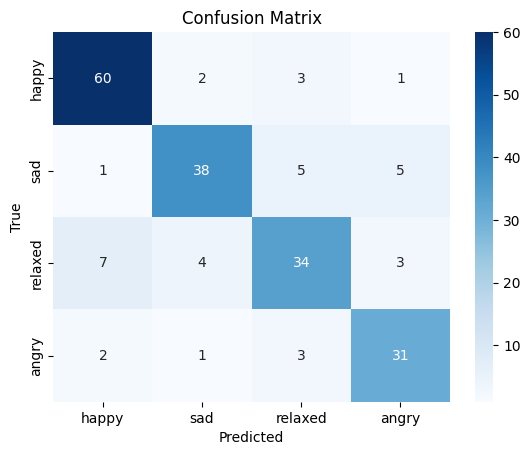

In [55]:
#confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
class_labels = ['happy', 'sad', 'relaxed', 'angry']
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)

# Set labels, title, and ticks
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels)
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels)
plt.show()

### Try KMeans Fail With Vector

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

class LyricsSupervisedKMeans:
    def __init__(self):
        self.vectorizer = CountVectorizer()
        self.kmeans = KMeans()
        self.norm_mean = None
        self.norm_std = None
    
    def set_lang(self, lang):
        pass
    
    def train(self, trainDf):
        # Convert lyrics to bag-of-words vectors
        X_train = self.vectorizer.fit_transform(trainDf['Vector'])
        X_train_norm = normalize(X_train)
        
        # Save normalization parameters
        self.norm_mean = np.mean(X_train_norm, axis=0)
        self.norm_std = np.std(X_train_norm, axis=0)
        
        # Apply normalization to training data
        X_train_norm = (X_train_norm - self.norm_mean) / self.norm_std
        
        # Train KMeans with labels
        y_train = trainDf['Mood']
        self.kmeans.fit(X_train_norm, y_train)
    
    def score(self, testDf):
        # Convert test lyrics to bag-of-words vectors
        X_test = self.vectorizer.transform(testDf['Vector'])
        
        # Normalize test data using saved parameters
        X_test_norm = normalize(X_test)
        X_test_norm = (X_test_norm - self.norm_mean) / self.norm_std
        
        # Predict labels with KMeans
        y_pred = self.kmeans.predict(X_test_norm)
        
        # Calculate accuracy
        acc = np.mean(y_pred == testDf['Mood'])
        return acc

# Load and preprocess dataset
dataset = dd

# Split dataset into training and test sets
trainDf, testDf = train_test_split(dataset, test_size=0.2)

# Train our model
clf = LyricsSupervisedKMeans()
clf.train(trainDf)

# Evaluate accuracy
acc = clf.score(testDf)
print('Accuracy: %0.2f' % (acc))


AttributeError: ignored

### Try LSTM

In [ ]:
!pip install --upgrade keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load and preprocess dataset
dataset = dd

# Encode labels
le = LabelEncoder()
dataset['Mood'] = le.fit_transform(dataset['Mood'])

# Split dataset into training and test sets
trainDf, testDf = train_test_split(dataset, test_size=0.2)

# Tokenize lyrics
max_words = 5000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(trainDf['Vector'])
X_train = tokenizer.texts_to_sequences(trainDf['Vector'])
X_test = tokenizer.texts_to_sequences(testDf['Vector'])

# Pad sequences
maxlen = 1000
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# Define LSTM model
embedding_size = 32
lstm_size = 64
vocab_size = min(len(tokenizer.word_index) + 1, max_words)
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=maxlen))
model.add(LSTM(lstm_size, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
batch_size = 32
epochs = 10
history = model.fit(X_train, trainDf['Mood'], batch_size=batch_size, epochs=epochs, validation_split=0.2)

# Evaluate model
loss, acc = model.evaluate(X_test, testDf['Mood'], batch_size=batch_size)
print('Accuracy: %0.2f' % (acc))


AttributeError: ignored